In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers.models.vit.modeling_vit import *

class ModViTForImageClassification(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__(config)

        self.num_labels = config.num_labels
        self.vit = ViTModel(config, add_pooling_layer=False, use_mask_token=True)

        # Classifier head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) if config.num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.vit(
            pixel_values,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


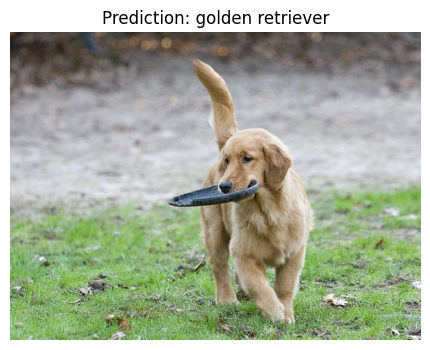

In [5]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

# 创建peft model 

In [6]:
from peft import LoraConfig, get_peft_model
# We use the same foundation model
exp_base_model = ViTModel.from_pretrained(pretrained_name)

# convert to peft model and ready to use LoRA 
# 手动列出所有层的目标模块

target_modules = []
num_layers = 12  # BERT-base 有 12 层
for i in range(num_layers):
    target_modules.extend([
        f"encoder.layer.{i}.attention.attention.query",
        f"encoder.layer.{i}.attention.attention.key",
        f"encoder.layer.{i}.attention.attention.value",
        f"encoder.layer.{i}.attention.output.dense",
        f"encoder.layer.{i}.intermediate.dense",
        f"encoder.layer.{i}.output.dense"
    ])

lora_config = LoraConfig(
    r=4,  # 低秩矩阵的秩
    lora_alpha=32,  # LoRA 的缩放因子
    target_modules= target_modules,  # 目标模块
    lora_dropout=0.1  # Dropout 概率
)
exp_base_model = get_peft_model(exp_base_model, lora_config)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from maskgen.vision_models.vision_maskgen_lora_allclass import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

In [8]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()
dataset = load_dataset("mrm8488/ImageNet1K-val")['train']

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
dataset.set_transform(preprocess)


batch_size = 256
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
# train_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [9]:
from tqdm import tqdm

optimizer = torch.optim.Adam(mask_gen_model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(5):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)
        # sim = mask_gen_model.forward(model=pred_model, pixel_values=pixel_values)
        # mask, masked_pred_logits = mask_gen_model.sample_one_step(model=pred_model, pixel_values=pixel_values, sim=sim)
        # pred_logits = mask_gen_model.get_pred_logits(model=pred_model, pixel_values=pixel_values)
        # loss_dict = mask_gen_model.loss_func(sim=sim, mask=mask, masked_pred_logits=masked_pred_logits, pred_logits=pred_logits)
        loss_dict = mask_gen_model.loss_func_v2(model=pred_model, pixel_values=pixel_values, num_samples=1)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss_dict['loss'].item():.4f}, " 
                             f"Reward Loss = {loss_dict['reward_loss'].item():.4f}, "
                             f"reward = {loss_dict['reward'].item():.4f}, "
                             f"advantage = {loss_dict['advantage'].item():.4f}, "
                             f"Mask Loss = {loss_dict['mask_loss'].item():.4f} "
                            #  f"mask_mean = {loss_dict['mask_mean'].item():.4f} "
                             f"prob_mean = {loss_dict['prob_mean'].item():.4f} "
                             )
        if idx % 10 == 0:
            print()



Epoch 1, Step 1: Loss = 0.4173, Reward Loss = 0.3457, reward = 0.5198, advantage = 0.1198, Mask Loss = 0.0716 prob_mean = 0.4918 :   1%|          | 1/196 [00:04<14:40,  4.52s/it]

Epoch 1, Step 11: Loss = 0.3434, Reward Loss = 0.2909, reward = 0.4585, advantage = 0.0585, Mask Loss = 0.0525 prob_mean = 0.4872 :   6%|▌         | 11/196 [00:50<14:08,  4.58s/it]

Epoch 1, Step 21: Loss = 0.2185, Reward Loss = 0.2141, reward = 0.3528, advantage = -0.0472, Mask Loss = 0.0044 prob_mean = 0.4289 :  11%|█         | 21/196 [01:37<13:25,  4.60s/it]

Epoch 1, Step 31: Loss = 0.1905, Reward Loss = 0.1874, reward = 0.3115, advantage = -0.0885, Mask Loss = 0.0030 prob_mean = 0.4037 :  16%|█▌        | 31/196 [02:24<13:02,  4.74s/it]

Epoch 1, Step 41: Loss = 0.2276, Reward Loss = 0.2198, reward = 0.3558, advantage = -0.0442, Mask Loss = 0.0077 prob_mean = 0.4163 :  21%|██        | 41/196 [03:10<12:00,  4.65s/it] 

Epoch 1, Step 51: Loss = 0.2508, Reward Loss = 0.2336, reward = 0.3852, advantage = -0.0148, Mask Loss = 0.0172 prob_mean = 0.4327 :  26%|██▌       | 51/196 [03:56<11:10,  4.62s/it] 

Epoch 1, Step 61: Loss = 0.2168, Reward Loss = 0.2147, reward = 0.3470, advantage = -0.0530, Mask Loss = 0.0021 prob_mean = 0.4288 :  31%|███       | 61/196 [04:42<10:16,  4.57s/it] 

Epoch 1, Step 71: Loss = 0.3217, Reward Loss = 0.2720, reward = 0.4450, advantage = 0.0450, Mask Loss = 0.0497 prob_mean = 0.4471 :  36%|███▌      | 71/196 [05:29<09:46,  4.69s/it]  

Epoch 1, Step 81: Loss = 0.2825, Reward Loss = 0.2477, reward = 0.4079, advantage = 0.0079, Mask Loss = 0.0348 prob_mean = 0.4392 :  41%|████▏     | 81/196 [06:15<08:53,  4.64s/it]  

Epoch 1, Step 91: Loss = 0.3144, Reward Loss = 0.2686, reward = 0.4323, advantage = 0.0323, Mask Loss = 0.0458 prob_mean = 0.4503 :  46%|████▋     | 91/196 [07:01<07:59,  4.57s/it] 

Epoch 1, Step 101: Loss = 0.2599, Reward Loss = 0.2381, reward = 0.3957, advantage = -0.0043, Mask Loss = 0.0218 prob_mean = 0.4341 :  52%|█████▏    | 101/196 [07:48<07:20,  4.64s/it]

Epoch 1, Step 111: Loss = 0.2309, Reward Loss = 0.2201, reward = 0.3659, advantage = -0.0341, Mask Loss = 0.0108 prob_mean = 0.4414 :  57%|█████▋    | 111/196 [08:34<06:29,  4.58s/it] 

Epoch 1, Step 121: Loss = 0.2589, Reward Loss = 0.2402, reward = 0.3992, advantage = -0.0008, Mask Loss = 0.0188 prob_mean = 0.4691 :  62%|██████▏   | 121/196 [09:20<05:43,  4.58s/it] 

Epoch 1, Step 131: Loss = 0.3301, Reward Loss = 0.2804, reward = 0.4604, advantage = 0.0604, Mask Loss = 0.0497 prob_mean = 0.4752 :  67%|██████▋   | 131/196 [10:06<05:05,  4.69s/it] 

Epoch 1, Step 141: Loss = 0.2682, Reward Loss = 0.2426, reward = 0.4037, advantage = 0.0037, Mask Loss = 0.0255 prob_mean = 0.4531 :  72%|███████▏  | 141/196 [10:52<04:19,  4.72s/it]  

Epoch 1, Step 151: Loss = 0.2252, Reward Loss = 0.2154, reward = 0.3591, advantage = -0.0409, Mask Loss = 0.0098 prob_mean = 0.4428 :  77%|███████▋  | 151/196 [11:39<03:33,  4.74s/it] 

Epoch 1, Step 161: Loss = 0.2023, Reward Loss = 0.2034, reward = 0.3432, advantage = -0.0568, Mask Loss = -0.0011 prob_mean = 0.4443 :  82%|████████▏ | 161/196 [12:26<02:43,  4.68s/it]

Epoch 1, Step 171: Loss = 0.2989, Reward Loss = 0.2599, reward = 0.4373, advantage = 0.0373, Mask Loss = 0.0390 prob_mean = 0.4770 :  87%|████████▋ | 171/196 [13:11<01:48,  4.34s/it]  

Epoch 1, Step 181: Loss = 0.2572, Reward Loss = 0.2330, reward = 0.3954, advantage = -0.0046, Mask Loss = 0.0243 prob_mean = 0.4900 :  92%|█████████▏| 181/196 [13:58<01:11,  4.74s/it]

Epoch 1, Step 191: Loss = 0.2898, Reward Loss = 0.2568, reward = 0.4248, advantage = 0.0248, Mask Loss = 0.0330 prob_mean = 0.4671 :  97%|█████████▋| 191/196 [14:44<00:23,  4.61s/it] 

Epoch 1, Step 196: Loss = 0.1503, Reward Loss = 0.1771, reward = 0.3032, advantage = -0.0968, Mask Loss = -0.0268 prob_mean = 0.4547 : 100%|██████████| 196/196 [15:04<00:00,  4.61s/it]
Epoch 2, Step 1: Loss = 0.2056, Reward Loss = 0.2047, reward = 0.3488, advantage = -0.0512, Mask Loss = 0.0009 prob_mean = 0.4714 :   1%|          | 1/196 [00:04<15:40,  4.83s/it]

Epoch 2, Step 11: Loss = 0.2667, Reward Loss = 0.2321, reward = 0.3950, advantage = -0.0050, Mask Loss = 0.0346 prob_mean = 0.4835 :   6%|▌         | 11/196 [00:51<14:21,  4.66s/it]

Epoch 2, Step 19: Loss = 0.3134, Reward Loss = 0.2511, reward = 0.4396, advantage = 0.0396, Mask Loss = 0.0623 prob_mean = 0.4834 :  10%|▉         | 19/196 [01:33<14:28,  4.91s/it]  


KeyboardInterrupt: 

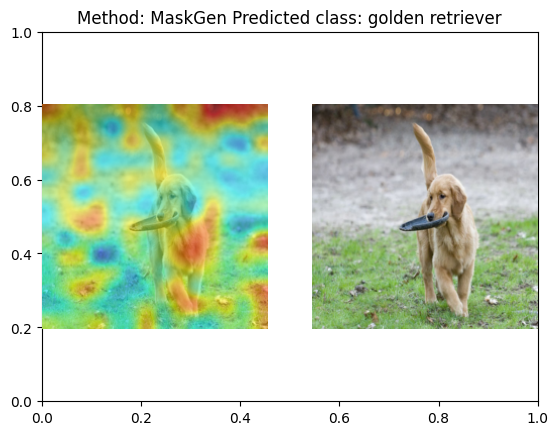

In [13]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils import idx_to_selector

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg?"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    pred_class = pred_model(img).logits.argmax(-1)
    predicted_class_idx = pred_class.item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
size = 14
N = inputs['pixel_values'].shape[0]

sim = mask_gen_model.forward(pixel_values=inputs['pixel_values'])
# selector = idx_to_selector(pred_class, 1000).unsqueeze(1) # [N, 1, n_classes]
# sim = (sim * selector).sum(-1)
sim = sim[:,:, predicted_class_idx]

heatmap = torch.sigmoid(sim).reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [ ]:
print(heatmap.min())
print(heatmap.max())
print(heatmap.mean())

0.48122758
0.8162256
0.65155137


In [ ]:
# save model to trained folder
import os
from datetime import datetime
state_dict = mask_gen_model.state_dict()
model_name = "vision_mask_gen_lora_" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".pt"
model_path = os.path.join("trained", model_name)
torch.save(state_dict, model_path)


In [ ]:
# how to check the size of the model in MB
import os
print(f"Model size: {os.path.getsize(model_path) / 1e6:.2f} MB")

Model size: 351.51 MB
